In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split

## 1. Loading and transforming training data 

In [2]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'

my_df = pd.read_csv(url, sep=',')
my_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
my_df['species'] = my_df['species'].replace('setosa', 0.0)
my_df['species'] = my_df['species'].replace('versicolor', 1.0)
my_df['species'] = my_df['species'].replace('virginica', 2.0)

/var/folders/_5/czqg39w944j1f37r_0v782_m0000gn/T/ipykernel_1598/1541532201.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['species'] = my_df['species'].replace('virginica', 2.0)


In [4]:
# Train test split! Set x, y
X = my_df.drop('species', axis=1)
y = my_df['species']

In [21]:
my_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [5]:
# Convert these into numpy arrays
X = X.values
y = y.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [7]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [8]:
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## 2. model design

In [9]:
# Create a model class that inherits nn.module
class Model(nn.Module):
    # Input layer (4 features of the flower) --> hidden layer (number of neurons) --> hiddent layer 2 --> output (3 classes of iris flowers)
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__() # Instantiate our nn.module
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.output = nn.Linear(h2, out_features)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x

In [10]:
# Pick a manual seed for randomisation
torch.manual_seed(32)
# Create an instance of model
model = Model()

In [11]:
# Set the criterion of th emodel to measure the error, how far off the predictions are from the true label
criterion = nn.CrossEntropyLoss()
# Choose Adam Optimiser, lr = learning rate (if error doesn't go down after a bunch of iterations, we lower learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 3. Model training loop

In [12]:
# Model training
epochs = 100
losses = []
for i in range(epochs):
    # Go forward and get a prediction
    y_pred = model.forward(X_train) # get predicted results
    # Measure the loss/error, will be high at first
    loss = criterion(y_pred, y_train) # predicted values vs the y_train

    # Keep track of our losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

    # Back propagation: take the error rate of forward propagation and feed it back through the network to fine tune the weights
    optimizer.zero_grad() # reset gradients to all optimized torch.tensors before forward/backward
    loss.backward() # Compute the gradient for current tensor w.r.t. graph leaves
    optimizer.step() # Update the model's parameters based on the gradients computed during the backpropagation phase

Epoch: 0 and loss: 1.169895887374878
Epoch: 10 and loss: 0.9578844308853149
Epoch: 20 and loss: 0.7988812327384949
Epoch: 30 and loss: 0.634953498840332
Epoch: 40 and loss: 0.44043004512786865
Epoch: 50 and loss: 0.29171696305274963
Epoch: 60 and loss: 0.1782904416322708
Epoch: 70 and loss: 0.11587586998939514
Epoch: 80 and loss: 0.08928148448467255
Epoch: 90 and loss: 0.077437624335289


Text(0.5, 0, 'Epoch')

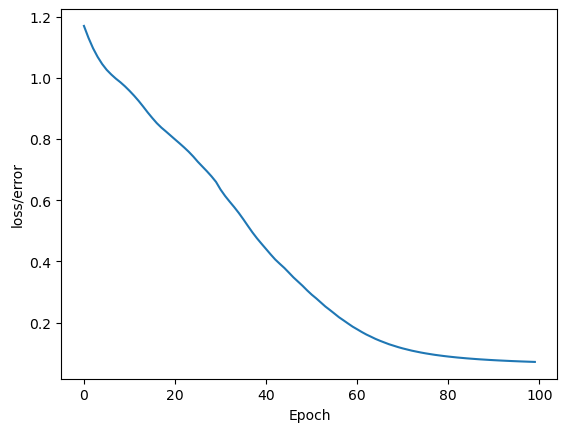

In [13]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("Epoch")

## 4. Test set evaluation

In [14]:
with torch.no_grad():
    y_eval = model.forward(X_test) 
    loss = criterion(y_eval, y_test)
loss

tensor(0.0539)

In [16]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_eval = model.forward(data)
        print(f'{i+1}.) prediction is {str(y_eval.argmax().item())}, actual is {str(y_test[i].item())} ')
        if y_eval.argmax().item() == y_test[i].item():
            correct += 1
        

1.) prediction is 1, actual is 1 
2.) prediction is 0, actual is 0 
3.) prediction is 0, actual is 0 
4.) prediction is 1, actual is 1 
5.) prediction is 2, actual is 2 
6.) prediction is 2, actual is 2 
7.) prediction is 0, actual is 0 
8.) prediction is 0, actual is 0 
9.) prediction is 1, actual is 1 
10.) prediction is 0, actual is 0 
11.) prediction is 1, actual is 1 
12.) prediction is 2, actual is 2 
13.) prediction is 1, actual is 1 
14.) prediction is 1, actual is 1 
15.) prediction is 2, actual is 2 
16.) prediction is 2, actual is 2 
17.) prediction is 1, actual is 1 
18.) prediction is 2, actual is 2 
19.) prediction is 1, actual is 1 
20.) prediction is 0, actual is 0 
21.) prediction is 0, actual is 0 
22.) prediction is 2, actual is 2 
23.) prediction is 2, actual is 2 
24.) prediction is 0, actual is 0 
25.) prediction is 0, actual is 0 
26.) prediction is 1, actual is 1 
27.) prediction is 0, actual is 0 
28.) prediction is 2, actual is 2 
29.) prediction is 0, actual 

In [17]:
correct

30

## 5. model inference on new data

In [24]:
new_iris = torch.tensor([6.7, 3.0, 5.2, 2.3])

In [25]:
with torch.no_grad():
    print(model(new_iris))

tensor([-8.7797,  2.0760,  6.9604])


## 6. Save/load model

In [ ]:
# Saving the model
torch.save(model.state_dict(), "my_model.pt")

In [33]:
# Load the saved model

new_model = Model()
new_model.load_state_dict(torch.load("my_model.pt"))

<All keys matched successfully>

In [34]:
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (output): Linear(in_features=9, out_features=3, bias=True)
)